## Part 1

In this section we create a class Boltzmann_N_spins which solves the ground state of the N-spin chain using gradient descent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import minimize
import random as rnd

# Find the exact solution by hand

class Boltzmann_N_spins:
    """Class Boltzmann computes an optimal wave function for
    a given hamiltonian and initial w = a, b, W """
    def __init__(self, hamiltonian, n = 2):
        self.n = n
        self.hamiltonian = hamiltonian    # function which is defined outside
        self.w_optimal = np.nan    # optimal w = a, b, W      
        self.psi_optimal = np.nan    # optimal psi corresponding to the optimal w
        self.min_energy = np.nan    # minimal energy corresponding to the optimal psi
        self.energy_optimization_history = []
        
    ########### PSI #################################
    
    def psi_M(self, S, w):    # Works for complex w, however, runtime errors
        """Returns a component of a wavefunction
        in the S direction
        psi is given in form of an array and works for any number of spins"""
        a, b, W = w[0], w[1], w[2]
        psi = np.exp(np.sum(a * S))
#         print('W ===', len(W))
        for i in range(len(W)):
            Fi = 2 * np.cosh(b[i] + np.sum(W[i] * S))
            psi *= Fi
        return psi

    def compute_psi(self, w):
        """Computes psi for w = a,b,W 
        psi is given in form of an array and works for any number of spins"""
        n = len(w[0])
        s = generate_spins(n)
        psi = np.zeros(2 ** n, dtype = 'complex')
        for i in range(len(psi)):
            psi[i] = self.psi_M(s[i], w)
        return psi
    
    def compute_psi_scipy(self, w_scipy):
        """Computes psi when for a given w_scipy"""
        w = self.convert_w_from_scipy(w_scipy)
        return self.compute_psi(w)
    
    def normalize(self, psi):
        """Returns normalized psi"""
        psi_star = np.transpose(np.conjugate(psi))
        return psi / np.sqrt(np.sum(psi_star @ psi))
        
    def show_psi(self, psi):
        """psi is a vector with lenght 2^n"""
        s = 'psi = '
        accuracy = '%.2f'
        for i in range(len(psi)):
            basis = bin(i)
            while len(basis) < len(bin(len(psi))) - 1:
                basis = basis[0:2] + '0' + basis[2:]
            if np.real(psi[i]) >= 0:
#                 s += '(' + str('%.5f' % np.real(psi[i])) + ' + i' + str('%.5f' % np.imag(psi[i])) + ')|' + basis[2:] + '>' + ' + '
                s += '(' + str(accuracy % np.real(psi[i])) + ' + ' + str(accuracy % np.imag(psi[i])) + 'i)|' + basis[2:] + '>' + ' + '
            else:
                s += '(' + str(accuracy % np.real(psi[i])) + ' - ' + str(accuracy % np.imag(-psi[i])) + 'i)|' + basis[2:] + '>' + ' + '
        print(s[:-3])
    
    def show_psi_optimal(self):
        """Shows optimal psi"""
        if self.psi_optimal is np.nan:
            raise ValueError('The optimal psi is not computed yet')
        self.show_psi(self.psi_optimal)
    
    ########### PSI #################################
    ########### OMEGA ###############################
    
    def find_len_a(self, N):
        """Returns the size of a for a given length 
        N of w = a,b,W in a form of 1D array"""
        l = 0
        while 2 * l + l ** 2 != N:
            l += 1
        return l
    
    def convert_w_to_scipy(self, w):
        """Converts w = a, b, W into scipy form"""
        a, b, W = w[0], w[1], w[2]
        w_scipy = np.zeros(2 * (len(a) + len(b) + len(W) * len(W[0]))) # w_scipy = [real(a[0]), imag(a[0]), real(a[1]), ...]
        for i in range(len(a)):
            w_scipy[2 * i] = np.real(a[i])
            w_scipy[2 * i + 1] = np.imag(a[i])
        for i in range(len(b)):
            w_scipy[2 * (len(a) + i)] = np.real(b[i])
            w_scipy[2 * (len(a) + i) + 1] = np.imag(b[i])
        for i in range(len(W)):
            for j in range(len(W[0])):
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j)] = np.real(W[i][j])
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j) + 1] = np.imag(W[i][j])
        return w_scipy
    
    def convert_w_from_scipy(self, w_scipy):
        """From w in scipy form returns w = a, b, W"""
        w = np.zeros(len(w_scipy) // 2, dtype = 'complex')
        for i in range(len(w)):
            w[i] = w_scipy[2 * i] + 1j * w_scipy[2 * i + 1]
        l = self.find_len_a(len(w))
        a, b = w[:l], w[l : 2 * l]
        W = np.resize(w[2 * l + 1:], (l, l))
        return a, b, W
    
    def show_omega_optimal(self):
        """Shows optimal w"""
        w = self.w_optimal
        a, b, W = w[0], w[1], w[2]
        print('a = ', a, '\nb = ', b, '\nW = ', W)
        
    ########### OMEGA ###############################
    ########### ENERGY ##############################
    
    def avg_energy(self, psi):
        """Returns the average energy for a given  wavefunciton
        and a given hamiltonian
        <E> = <psi|H|psi> / <psi|psi>"""
        psi_star = np.transpose(np.conjugate(psi))
        return np.sum(psi_star * self.hamiltonian(psi)) / np.sum(psi_star * psi)
    
    def avg_energy_scipy(self, w_scipy):
        """Returns the average energy for a given configuration w,
        made to work for scipy.optimize.minimize
        Size of w is 2N, even is real, odd is complex"""
        psi = self.compute_psi_scipy(w_scipy)
        self.energy_optimization_history.append(self.avg_energy(psi))
        return np.real(self.avg_energy(psi))
#         return self.avg_energy(psi)
    
    def show_min_energy(self):
        if self.min_energy is np.nan:
            raise ValueError('The optimal energy is not computed yet')
        s = 'E_min = ' + str(self.min_energy)
        print(s)
    
    ########### ENERGY ##############################
    ########### OPTIMIZATION ########################
    
    def find_optimal_psi(self, w0, tolerance = None):
        """For a given hamiltonian searches for the
        ground state, i.e. the psi which minimizes the energy"""
        w0_scipy = self.convert_w_to_scipy(w0)
#         w_min = minimize(self.avg_energy_scipy, w0_scipy)    # x0 is now complex, size 2N, even spots real, odd imag
        w_min = minimize(self.avg_energy_scipy, w0_scipy, tol = tolerance)    # x0 is now complex, size 2N, even spots real, odd imag
        w_optimal_scipy = w_min.x
        self.w_optimal = self.convert_w_from_scipy(w_optimal_scipy)    # w_optimal is in a, b, W form
        self.psi_optimal = self.compute_psi(self.w_optimal)
        self.min_energy = self.avg_energy(self.psi_optimal)
    
    ########### OPTIMIZATION ########################
    

def normalize(psi):
        """Returns normalized psi"""
        psi_star = np.transpose(np.conjugate(psi))
        return psi / np.sqrt(np.sum(psi_star @ psi))

########### NEW HAMILTONIAN #########################

def sigma_x(psi):
    """Applies sum sigma_x_i on a given 
    wavefunction psi (in form of 1D array) and returns the 
    new wavefunciton psi1"""
    n = len(psi)
    psi1 = np.zeros((n), dtype = 'complex')
    for i in range(n):
        # s = 1001 meaning |1001>, iterates through all the possible states 001, 010, 011 ...
        s = bin(i)
        # instead of i = 1 ==> b = 0b1, we want b = 0b001, for 3 spins
        while len(s) < len(bin(n)) - 1:
            s = s[0:2] + '0' + s[2:]
        for j in range(len(s[2:])):
            s1 = ''    # flipping all the possible bits once; 101 would give s1: 100, 111, 001
            for k in s:    # constructing s1 as a function of j               j:  0,   1,   2
                if j - 1 == len(s[2:]) - len(s1):
                    if k == '0':
                        s1 += '1'
                    else:
                        s1 += '0'
                else:
                    s1 += k
            i1 = int(s1, 2)
#             print(s, s1)
#             print(i, i1)
            psi1[i1] += psi[i]
    return psi1

def double_sigma_z(psi):
    """Applies  sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n = len(psi)
    n_spins = int(np.log2(n))
    psi_sigma_z = np.zeros(len(psi), dtype = 'complex')
    if n == 4:
        for i in range(len(psi)):
            psi_sigma_z[i] = psi[i]
        psi_sigma_z[1] *= -1
        psi_sigma_z[2] *= -1
    else:
        s = generate_spins(n_spins)
        for i in range(n):
            for j in range(n_spins):
                psi_sigma_z[i] += (-1) ** (1 + (s[i][j] + s[i][(j + 1) % len(s[0])]) // 2) * psi[i]
    return psi_sigma_z

def hamiltonian(psi):
    """Retuns wave function after the TFI Hamiltonian 
    acts on it, with h = 1 (to be modified later)"""
#     return h * sigma_x(psi)
    return - h * sigma_x(psi) - double_sigma_z(psi)

def generate_spins(n):
    s = np.zeros((2 ** n, n))
    for i in range(2 ** n):
        b = bin(i)
        while len(b) < n + 2:
            b = b[0:2] + '0' + b[2:]
        d = []
        for k in b:
            if k == '0':
                d.append(-1)
#                     d.append(0)    # This could be more convenient, we'll see
            else:
                d.append(1)
        s[i] = np.array(d[2:])
    return s

########### NEW HAMILTONIAN #########################


In [75]:
########### INITIALIZATION ########################
n = 3
a = np.random.rand(n)
b = np.random.rand(n)
W = np.random.rand(n,n) + 1j * np.random.rand(n,n)
w = a, b, W
h = 1
boltzmann = Boltzmann_N_spins(hamiltonian, n)
########### INITIALIZATION ########################

########### OPTIMZATION ###########################
tolerance = 0.01
boltzmann.find_optimal_psi(w)
########### OPTIMZATION ###########################

########### EXTRACTING PARAMETERS #################
w_optimal = boltzmann.w_optimal
psi_optimal = boltzmann.psi_optimal
boltzmann.psi_optimal = normalize(psi_optimal)
min_energy = boltzmann.min_energy
########### EXTRACTING PARAMETERS #################

In [76]:
boltzmann.show_psi_optimal()
boltzmann.show_min_energy()
# boltzmann.show_omega_optimal()

psi = (0.21 + 0.57i)|000> + (0.07 + 0.19i)|001> + (0.07 + 0.19i)|010> + (0.07 + 0.19i)|011> + (0.07 + 0.19i)|100> + (0.07 + 0.19i)|101> + (0.07 + 0.19i)|110> + (0.21 + 0.57i)|111>
E_min = (-3.999999999994839+0j)


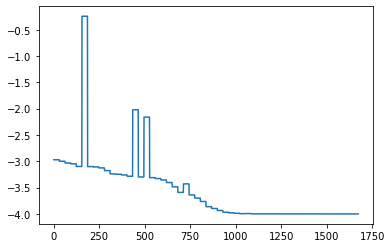

In [77]:
plt.plot(np.real(boltzmann.energy_optimization_history))

## Part 2

In this section we find the spin correlation in order to see if the obtained wave-function is physical.

In [78]:
def sigma_z_0_l(psi, l):
    """Applies  sigma_z_0 sigma_z_{l}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n_spins = int(np.log2(len(psi)))
    s = generate_spins(n_spins)
    psi_sigma_z = np.zeros(len(psi), dtype = 'complex')
    for i in range(len(psi_sigma_z)):
        psi_sigma_z[i] = s[i][0] * s[i][l] * psi[i]
    return psi_sigma_z

def spin_correlation(psi):
    """Returns array C which contains the correlation between
    the spin at position 0 and the spin on position i. C is
    of the length N_spins + 1, and C[-1] is set to C[0] 
    for visual purposes"""
    psi = normalize(psi)
    psi_star = np.transpose(np.conjugate(psi))
    n_spins = int(np.log2(len(psi)))
    C = np.zeros(n_spins + 1)
    for i in range(n_spins):
        C[i] = psi_star @ sigma_z_0_l(psi, i)
        print(C)
    C[-1] = C[0]
    return C

[1. 0. 0. 0.]
[1.         0.66666759 0.         0.        ]
[1.         0.66666759 0.66666712 0.        ]


<ipython-input-78-511f14430294>:22: ComplexWarning: Casting complex values to real discards the imaginary part
  C[i] = psi_star @ sigma_z_0_l(psi, i)


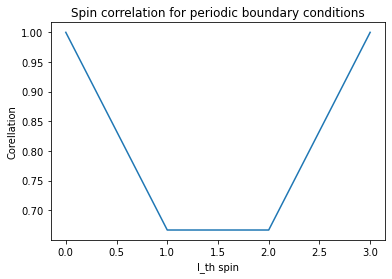

In [79]:
C = spin_correlation(psi_optimal)
plt.plot(np.real(C))
plt.title('Spin correlation for periodic boundary conditions')
plt.xlabel('l_th spin')
plt.ylabel('Corellation')
plt.savefig('Figures\\Spin correlation ' + str(n) + ' spins, h = ' + str(h) + '.png')

## Part 3

We modify the code from Part 1 to solve the system using stochastic gradient descent. This section is in progress, while the previous ones should be working completely.

In [80]:
def binary_to_decimal(s):
    """Returns the index correspoding to the state s"""
    ind = 0
    n = len(s)
    for i in range(n):
        if s[n - i - 1] == 1:
            ind += 2 ** i
    return ind

def index_of_spin(s):
    """Returns the index of a given spin"""
    n = len(s)
    ind = 0
    for i in range(n):
        if s[i] == 1:
            ind += 2 ** (n-i-1)
    return ind

def avg_energy_mc(w):
    """Computes average energy using stochastic
    gradient descent"""
    N_steps = 5
    S = generate_spins(len(w[0]))
    s = rnd.choice(generate_spins(len(w[0])))
    s_hist = np.zeros(len(S))
    E = np.zeros(N_steps)
    for i in range(N_steps):
        E[i], s = monte_carlo_step(s, w, hamiltonian, boltzmann)
#         print(np.argwhere(S == s)[0])
        s_hist[index_of_spin(s)] +=1
#     return np.zeros(N_steps), s_hist
#     return E, s_hist
    return np.average(E), s_hist

def monte_carlo_step(s, w, hamiltonian, boltzmann):
    """For a given pure state in a given hamiltonian,
    does a monte_carlo_step on a pure state"""
    n_spin = len(s)
#     a, b, W = w[0], w[1], w[2]
    ind = rnd.randint(0, n_spin - 1)
    s_new = s.copy()
    s_new[ind] *= -1
    # We compute the probability to accept the modification
    # as the ratio of psi_M(s_new) and psi_M(s)
    psi_M, psi_M_new = boltzmann.psi_M(s, w), boltzmann.psi_M(s_new, w)    # should be more efficient
    p = np.abs(psi_M_new * np.conjugate(psi_M_new) / (psi_M * np.conjugate(psi_M)))
    if rnd.random() < p:
        print(s)
        s = s_new
        print(s_new)
        print('***')
    else:
        print('REJECTED')
    # computing the change in the energy
    delta_E_mc = 0
    s_new = s.copy()
    for i in range(len(s)):    # sigma_x
        s_new[i] *= -1
        delta_E_mc += (-h) * boltzmann.psi_M(s_new, w) / boltzmann.psi_M(s, w)
        s_new[i] *= -1
    if len(s) == 2:
        delta_E_mc -= s[0] * s[1]    # double_sigma_z for 2 spins
    else:
        delta_E_mc -= sum(s[i] * s[(i + 1) % len(s)] for i in range(len(s)))    # double_sigma_z
    return delta_E_mc, s

def delta_E_mc_sigma_x(s):
    """Returns the enregy contribution of sigma_x
    to the stochastic energy"""
    E = 0
    for i in range(len(s)):
        E += (-h) * boltzmann.psi_M()


In [81]:
# computes stochastic E
E, s_hist = avg_energy_mc(w_optimal)

[ 1.  1. -1.]
[1. 1. 1.]
***
REJECTED
REJECTED
REJECTED
REJECTED


<ipython-input-80-0710ca813fb9>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i], s = monte_carlo_step(s, w, hamiltonian, boltzmann)


In [82]:
print('E = ', E)

E =  -3.9999984321498396


In [45]:
def plot_psi_M_probability(w, boltzmann):
    a, b, W = w[0], w[1], w[2]
    S = generate_spins(len(W))
    p = np.zeros(len(S), dtype = 'complex')
    for i in range(len(S)):
#         print(s)
        p[i] = np.real(np.transpose(np.conjugate(boltzmann.psi_M(S[i], w))) * boltzmann.psi_M(S[i], w))
#         print(p[i])
    plt.plot(p)
    return p

C:\Users\Filip\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


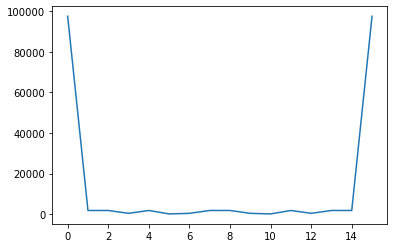

In [36]:
p = plot_psi_M_probability(w_optimal, boltzmann)

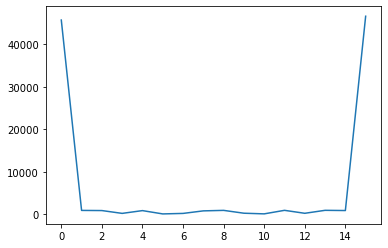

In [37]:
plt.plot(s_hist)

C:\Users\Filip\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


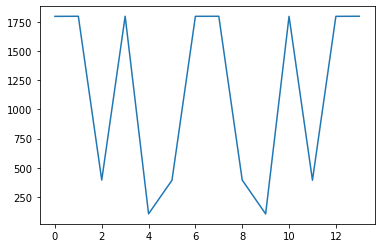

In [38]:
plt.plot(p[1:-1])

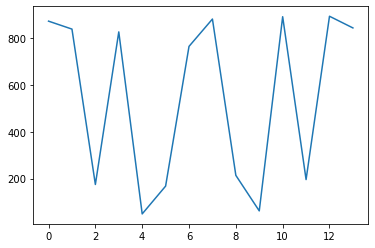

In [39]:
plt.plot(s_hist[1:-1])

In [ ]:
x = plt.hist(s_hist)[0]
# y = plt.hist(s_hist)[1]
# plt.hist(y)

In [ ]:
plt.hist(x)

In [ ]:
# s = generate_spins(4)
# for i in range(len(s)):
#     print('s = ', s[i])
#     print('E_z = ', delta_E_mc_double_sigma_z(s[i]))

In [ ]:
s = [1, 0, 1, 1, 1, 1]
binary_to_decimal(s)

In [ ]:
s = [1, 1, -1, -1]
ind = 1
flip_spin(s, ind)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import minimize
import random as rnd

# Find the exact solution by hand

class Boltzmann_N_spins:
    """Class Boltzmann computes an optimal wave function for
    a given hamiltonian and initial w = a, b, W """
    def __init__(self, hamiltonian, n = 2):
        self.n = n
        self.hamiltonian = hamiltonian    # function which is defined outside
        self.w_optimal = np.nan    # optimal w = a, b, W      
        self.psi_optimal = np.nan    # optimal psi corresponding to the optimal w
        self.min_energy = np.nan    # minimal energy corresponding to the optimal psi
        self.energy_optimization_history = []
        
    ########### PSI #################################
    
    def psi_M(self, S, w):    # Works for complex w, however, runtime errors
        """Returns a component of a wavefunction
        in the S direction
        psi is given in form of an array and works for any number of spins"""
        a, b, W = w[0], w[1], w[2]
        psi = np.exp(np.sum(a * S))
#         print('W ===', len(W))
        for i in range(len(W)):
            Fi = 2 * np.cosh(b[i] + np.sum(W[i] * S))
            psi *= Fi
        return psi

    def compute_psi(self, w):
        """Computes psi for w = a,b,W 
        psi is given in form of an array and works for any number of spins"""
        n = len(w[0])
        s = generate_spins(n)
        psi = np.zeros(2 ** n, dtype = 'complex')
        for i in range(len(psi)):
            psi[i] = self.psi_M(s[i], w)
        return psi
    
    def compute_psi_scipy(self, w_scipy):
        """Computes psi when for a given w_scipy"""
        w = self.convert_w_from_scipy(w_scipy)
        return self.compute_psi(w)
    
    def normalize(self, psi):
        """Returns normalized psi"""
        psi_star = np.transpose(np.conjugate(psi))
        return psi / np.sqrt(np.sum(psi_star @ psi))
        
    def show_psi(self, psi):
        """psi is a vector with lenght 2^n"""
        s = 'psi = '
        accuracy = '%.2f'
        for i in range(len(psi)):
            basis = bin(i)
            while len(basis) < len(bin(len(psi))) - 1:
                basis = basis[0:2] + '0' + basis[2:]
            if np.real(psi[i]) >= 0:
#                 s += '(' + str('%.5f' % np.real(psi[i])) + ' + i' + str('%.5f' % np.imag(psi[i])) + ')|' + basis[2:] + '>' + ' + '
                s += '(' + str(accuracy % np.real(psi[i])) + ' + ' + str(accuracy % np.imag(psi[i])) + 'i)|' + basis[2:] + '>' + ' + '
            else:
                s += '(' + str(accuracy % np.real(psi[i])) + ' - ' + str(accuracy % np.imag(-psi[i])) + 'i)|' + basis[2:] + '>' + ' + '
        print(s[:-3])
    
    def show_psi_optimal(self):
        """Shows optimal psi"""
        if self.psi_optimal is np.nan:
            raise ValueError('The optimal psi is not computed yet')
        self.show_psi(self.psi_optimal)
    
    ########### PSI #################################
    ########### OMEGA ###############################
    
    def find_len_a(self, N):
        """Returns the size of a for a given length 
        N of w = a,b,W in a form of 1D array"""
        l = 0
        while 2 * l + l ** 2 != N:
            l += 1
        return l
    
    def convert_w_to_scipy(self, w):
        """Converts w = a, b, W into scipy form"""
        a, b, W = w[0], w[1], w[2]
        w_scipy = np.zeros(2 * (len(a) + len(b) + len(W) * len(W[0]))) # w_scipy = [real(a[0]), imag(a[0]), real(a[1]), ...]
        for i in range(len(a)):
            w_scipy[2 * i] = np.real(a[i])
            w_scipy[2 * i + 1] = np.imag(a[i])
        for i in range(len(b)):
            w_scipy[2 * (len(a) + i)] = np.real(b[i])
            w_scipy[2 * (len(a) + i) + 1] = np.imag(b[i])
        for i in range(len(W)):
            for j in range(len(W[0])):
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j)] = np.real(W[i][j])
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j) + 1] = np.imag(W[i][j])
        return w_scipy
    
    def convert_w_from_scipy(self, w_scipy):
        """From w in scipy form returns w = a, b, W"""
        w = np.zeros(len(w_scipy) // 2, dtype = 'complex')
        for i in range(len(w)):
            w[i] = w_scipy[2 * i] + 1j * w_scipy[2 * i + 1]
        l = self.find_len_a(len(w))
        a, b = w[:l], w[l : 2 * l]
        W = np.resize(w[2 * l + 1:], (l, l))
        return a, b, W
    
    def show_omega_optimal(self):
        """Shows optimal w"""
        w = self.w_optimal
        a, b, W = w[0], w[1], w[2]
        print('a = ', a, '\nb = ', b, '\nW = ', W)
        
    ########### OMEGA ###############################
    ########### ENERGY ##############################
    
    def avg_energy(self, psi):
        """Returns the average energy for a given  wavefunciton
        and a given hamiltonian
        <E> = <psi|H|psi> / <psi|psi>"""
        psi_star = np.transpose(np.conjugate(psi))
        return np.sum(psi_star * self.hamiltonian(psi)) / np.sum(psi_star * psi)
    
    def avg_energy_scipy(self, w_scipy):
        """Returns the average energy for a given configuration w,
        made to work for scipy.optimize.minimize
        Size of w is 2N, even is real, odd is complex"""
        psi = self.compute_psi_scipy(w_scipy)
        self.energy_optimization_history.append(self.avg_energy(psi))
        return np.real(self.avg_energy(psi))
#         return self.avg_energy(psi)
    
    def show_min_energy(self):
        if self.min_energy is np.nan:
            raise ValueError('The optimal energy is not computed yet')
        s = 'E_min = ' + str(self.min_energy)
        print(s)
    
    ########### ENERGY ##############################
    ########### OPTIMIZATION ########################
    
    def find_optimal_psi(self, w0, tolerance = None):
        """For a given hamiltonian searches for the
        ground state, i.e. the psi which minimizes the energy"""
        w0_scipy = self.convert_w_to_scipy(w0)
#         w_min = minimize(self.avg_energy_scipy, w0_scipy)    # x0 is now complex, size 2N, even spots real, odd imag
        w_min = minimize(self.avg_energy_scipy, w0_scipy, tol = tolerance)    # x0 is now complex, size 2N, even spots real, odd imag
        w_optimal_scipy = w_min.x
        self.w_optimal = self.convert_w_from_scipy(w_optimal_scipy)    # w_optimal is in a, b, W form
        self.psi_optimal = self.compute_psi(self.w_optimal)
        self.min_energy = self.avg_energy(self.psi_optimal)
    
    ########### OPTIMIZATION ########################
    

def normalize(psi):
        """Returns normalized psi"""
        psi_star = np.transpose(np.conjugate(psi))
        return psi / np.sqrt(np.sum(psi_star @ psi))

########### NEW HAMILTONIAN #########################

def sigma_x(psi):
    """Applies sum sigma_x_i on a given 
    wavefunction psi (in form of 1D array) and returns the 
    new wavefunciton psi1"""
    n = len(psi)
    psi1 = np.zeros((n), dtype = 'complex')
    for i in range(n):
        # s = 1001 meaning |1001>, iterates through all the possible states 001, 010, 011 ...
        s = bin(i)
        # instead of i = 1 ==> b = 0b1, we want b = 0b001, for 3 spins
        while len(s) < len(bin(n)) - 1:
            s = s[0:2] + '0' + s[2:]
        for j in range(len(s[2:])):
            s1 = ''    # flipping all the possible bits once; 101 would give s1: 100, 111, 001
            for k in s:    # constructing s1 as a function of j               j:  0,   1,   2
                if j - 1 == len(s[2:]) - len(s1):
                    if k == '0':
                        s1 += '1'
                    else:
                        s1 += '0'
                else:
                    s1 += k
            i1 = int(s1, 2)
#             print(s, s1)
#             print(i, i1)
            psi1[i1] += psi[i]
    return psi1

def double_sigma_z(psi):
    """Applies  sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n = len(psi)
    n_spins = int(np.log2(n))
    psi_sigma_z = np.zeros(len(psi), dtype = 'complex')
    if n == 4:
        for i in range(len(psi)):
            psi_sigma_z[i] = psi[i]
        psi_sigma_z[1] *= -1
        psi_sigma_z[2] *= -1
    else:
        s = generate_spins(n_spins)
        for i in range(n):
            for j in range(n_spins):
                psi_sigma_z[i] += (-1) ** (1 + (s[i][j] + s[i][(j + 1) % len(s[0])]) // 2) * psi[i]
    return psi_sigma_z

def hamiltonian(psi):
    """Retuns wave function after the TFI Hamiltonian 
    acts on it, with h = 1 (to be modified later)"""
#     return h * sigma_x(psi)
    return - h * sigma_x(psi) - double_sigma_z(psi)

def generate_spins(n):
    s = np.zeros((2 ** n, n))
    for i in range(2 ** n):
        b = bin(i)
        while len(b) < n + 2:
            b = b[0:2] + '0' + b[2:]
        d = []
        for k in b:
            if k == '0':
                d.append(-1)
#                     d.append(0)    # This could be more convenient, we'll see
            else:
                d.append(1)
        s[i] = np.array(d[2:])
    return s

########### NEW HAMILTONIAN #########################


In [ ]:
a = np.array([1, 4])
rnd.randint(0, len(a) - 1)
b = a.copy()
print(a == b)
a[0] = 4
print(a)
print(b)

In [ ]:
a = np.array((2 + 1j, 1 - 6j))
a @ np.conjugate(a)

In [ ]:
import random as rnd
import numpy as np
rnd.choice(np.array((1,2,3)))

In [ ]:
a = np.array((1, 1, 0, 0, 1, 1 , 1))
np.count_nonzero(a == 1)